# Movie recommendation 

Recommendation systems have become predominant as of late as they managing the
data over-burden issue by recommending clients the most pertinent items from a
huge measure of information. For media item, online collaborative film recommendations
make endeavors to help clients to get to their favored films by catching 
comparable neighbors among clients or films from their authentic normal ratings

Recommendation systems use various echniques and algorithms to present relevant items to users that they migth be interested in. So in this notebook we will be creating a movie recommender system, the types of algorithms we willl be looking at are the:
- Content based recommender system 
- Collaborative filtering system


Installing dependencies 

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import math

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack, csr_matrix
import math


In [ ]:
#The jupyter notebook should be in the same file path as the movielens dataset

In [131]:
# Showing the files we have int eh dataset we have for our notebook.
#data_path = os.path.join(os.getcwd(),'movie_data' )
data_path = os.path.join(os.getcwd(),'movielens smaller' )
for filenames in os.listdir(data_path):
            print(os.path.join(data_path,filenames))

C:\Users\aeade\Desktop\Projects\AI\movielens smaller\movies.csv
C:\Users\aeade\Desktop\Projects\AI\movielens smaller\ratings.csv


In [132]:
movie_file= str(os.path.join(data_path,'movies.csv'))
rating_file = str(os.path.join(data_path,'ratings.csv'))

In [133]:
movie_data = pd.read_csv(movie_file)
rating_data = pd.read_csv(rating_file)

In [134]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [135]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [136]:
print(f"There are {movie_data.shape[0]} movies and {rating_data.shape[0]} ratings ")

There are 10329 movies and 105339 ratings 


### Performing Exploratory Data Analysis

In [137]:
#Checking details of the movie dataset
print('Info :', movie_data.info())

#Checking the statistics of the movie dataset
print('Movie_data description',movie_data.describe())

#Checking for null values
print('Null values' ,movie_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB
Info : None
Movie_data description              movieId
count   10329.000000
mean    31924.282893
std     37734.741149
min         1.000000
25%      3240.000000
50%      7088.000000
75%     59900.000000
max    149532.000000
Null values movieId    0
title      0
genres     0
dtype: int64


In [138]:
#Checking details of the rating dataset
print('Info :', rating_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB
Info : None


In [139]:
#Checking the statistics of the review dataset
print('Movie_data description',rating_data.describe())

Movie_data description               userId        movieId         rating     timestamp
count  105339.000000  105339.000000  105339.000000  1.053390e+05
mean      364.924539   13381.312477       3.516850  1.130424e+09
std       197.486905   26170.456869       1.044872  1.802660e+08
min         1.000000       1.000000       0.500000  8.285650e+08
25%       192.000000    1073.000000       3.000000  9.711008e+08
50%       383.000000    2497.000000       3.500000  1.115154e+09
75%       557.000000    5991.000000       4.000000  1.275496e+09
max       668.000000  149532.000000       5.000000  1.452405e+09


In [140]:
#Checking for null values
print('Null values' , rating_data.isnull().sum())

Null values userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


From the descriptions above, both datasts don't have missing or duplicated values

In [141]:
#Checking the number of ratings made by each user:
print('Number of ratings made by each user:\n', rating_data.groupby(by='userId').size())

Number of ratings made by each user:
 userId
1       113
2        29
3        73
4       124
5        68
       ... 
664      74
665     227
666     225
667      74
668    5678
Length: 668, dtype: int64


In [142]:
# Showing the highest occurence of ratings
print('Count of most given ratings in desc order:\n')
rating_data['rating'].value_counts()

Count of most given ratings in desc order:



4.0    28880
3.0    21729
5.0    14856
3.5    12237
4.5     8187
2.0     7943
2.5     5484
1.0     3258
1.5     1567
0.5     1198
Name: rating, dtype: int64

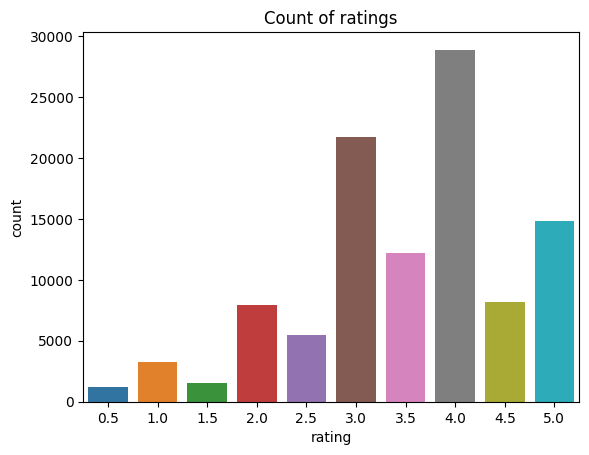

In [143]:
# Plotting a histogram of ratings
sns.countplot(data=rating_data, x='rating')
plt.title('Count of ratings')
plt.show()

### Data preprocessing

In [144]:
#The year of release of the movies are written in the titles, so we'll exrtract them and make them a feeature
movie_data['year'] = movie_data['title'].str.extract(r'\((\d{4})\)')

In [145]:
#Checking how many null values we have in the dataset
movie_data.isnull().sum()

movieId    0
title      0
genres     0
year       3
dtype: int64

In [146]:
movie_data.loc[movie_data['year'].isnull()].head()

,movieId,title,genres,year
9885,108583,Fawlty Towers (1975-1979),Comedy,NaN
10172,126929,Li'l Quinquin ( ),(no genres listed),NaN
10322,146344,Elämältä kaiken sain ( ),Comedy|Drama,NaN


In [147]:
# Taking out movies without a valid year of release
movie_data.dropna(subset=['year'], inplace=True)

In [148]:
pd.DataFrame(movie_data['year'].astype(int)).head(7)

,year
0,1995
1,1995
2,1995
3,1995
4,1995
5,1995
6,1995


Now considering the ratings per year from 1995

In [149]:
year_ratings = pd.merge(movie_data, rating_data,left_on = 'movieId', right_on = 'movieId',how = 'left')

In [150]:
year_ratings

,movieId,title,genres,year,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,2.0,5.0,8.590469e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5.0,4.0,1.303501e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,8.0,5.0,8.586109e+08
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,11.0,4.0,8.508158e+08
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,14.0,4.0,8.517663e+08
...,...,...,...,...,...,...,...
105331,148238,A Very Murray Christmas (2015),Comedy,2015,475.0,3.0,1.451213e+09
105332,148626,The Big Short (2015),Drama,2015,458.0,4.0,1.452015e+09
105333,148626,The Big Short (2015),Drama,2015,576.0,4.5,1.451688e+09
105334,148626,The Big Short (2015),Drama,2015,668.0,4.5,1.451148e+09


In [151]:
year_ratings['year'] = year_ratings['year'].astype(int)

In [152]:
year_ratings = year_ratings[year_ratings['year'] >= 1995]

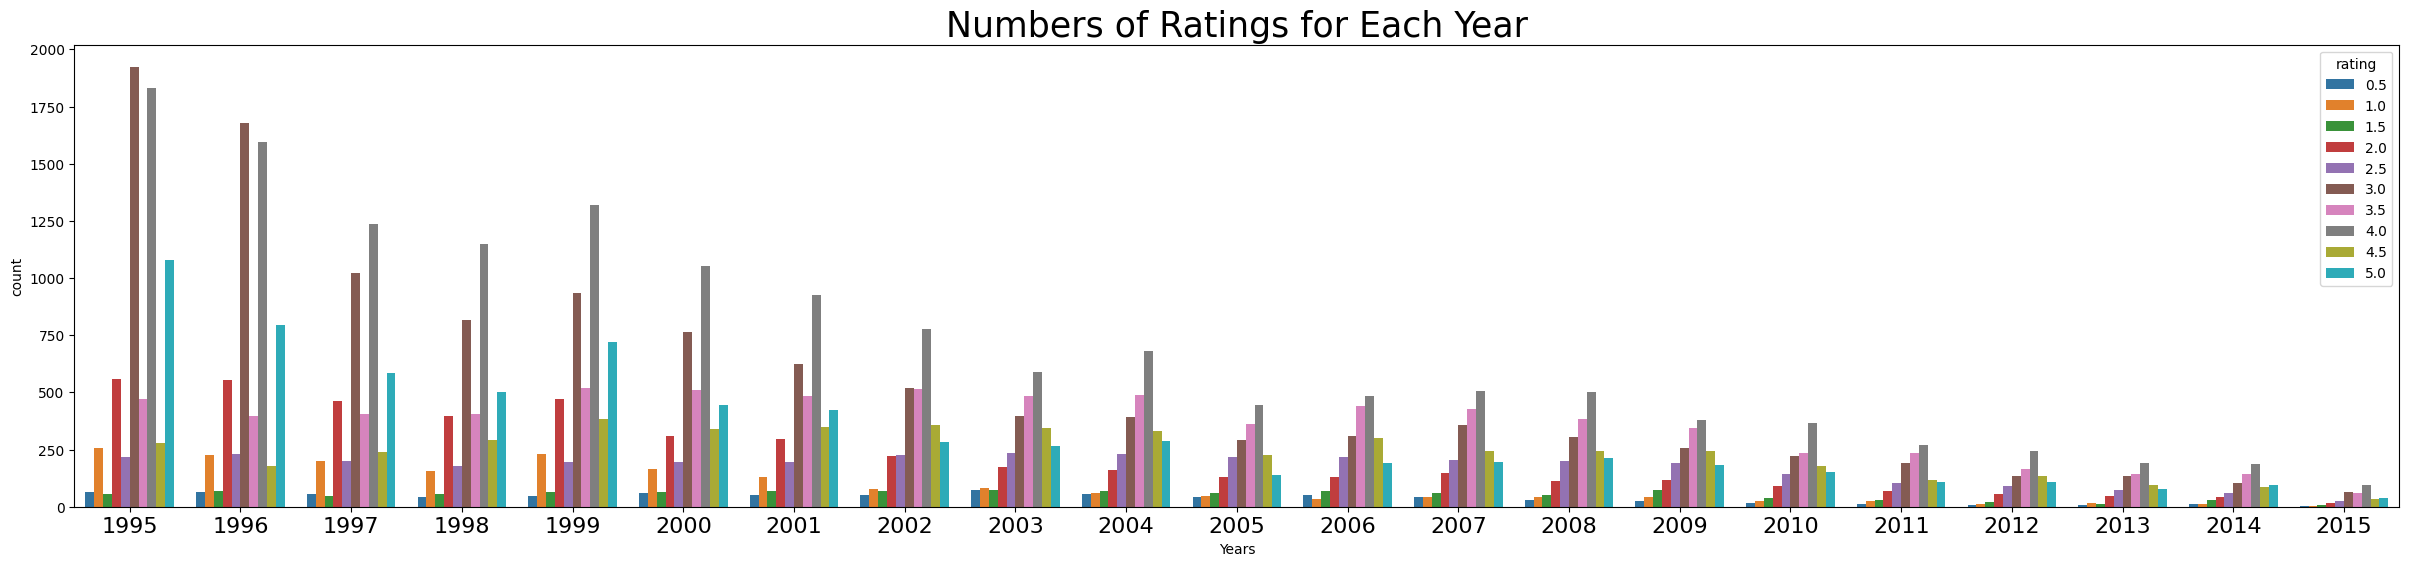

In [153]:
plt.figure(figsize= (30, 6))

sns.countplot(data = year_ratings, x=year_ratings.year,
              hue= year_ratings.rating)

plt.title('Numbers of Ratings for Each Year', size= 25)
plt.xlabel("Years")
plt.xticks(size= 16)

plt.show()

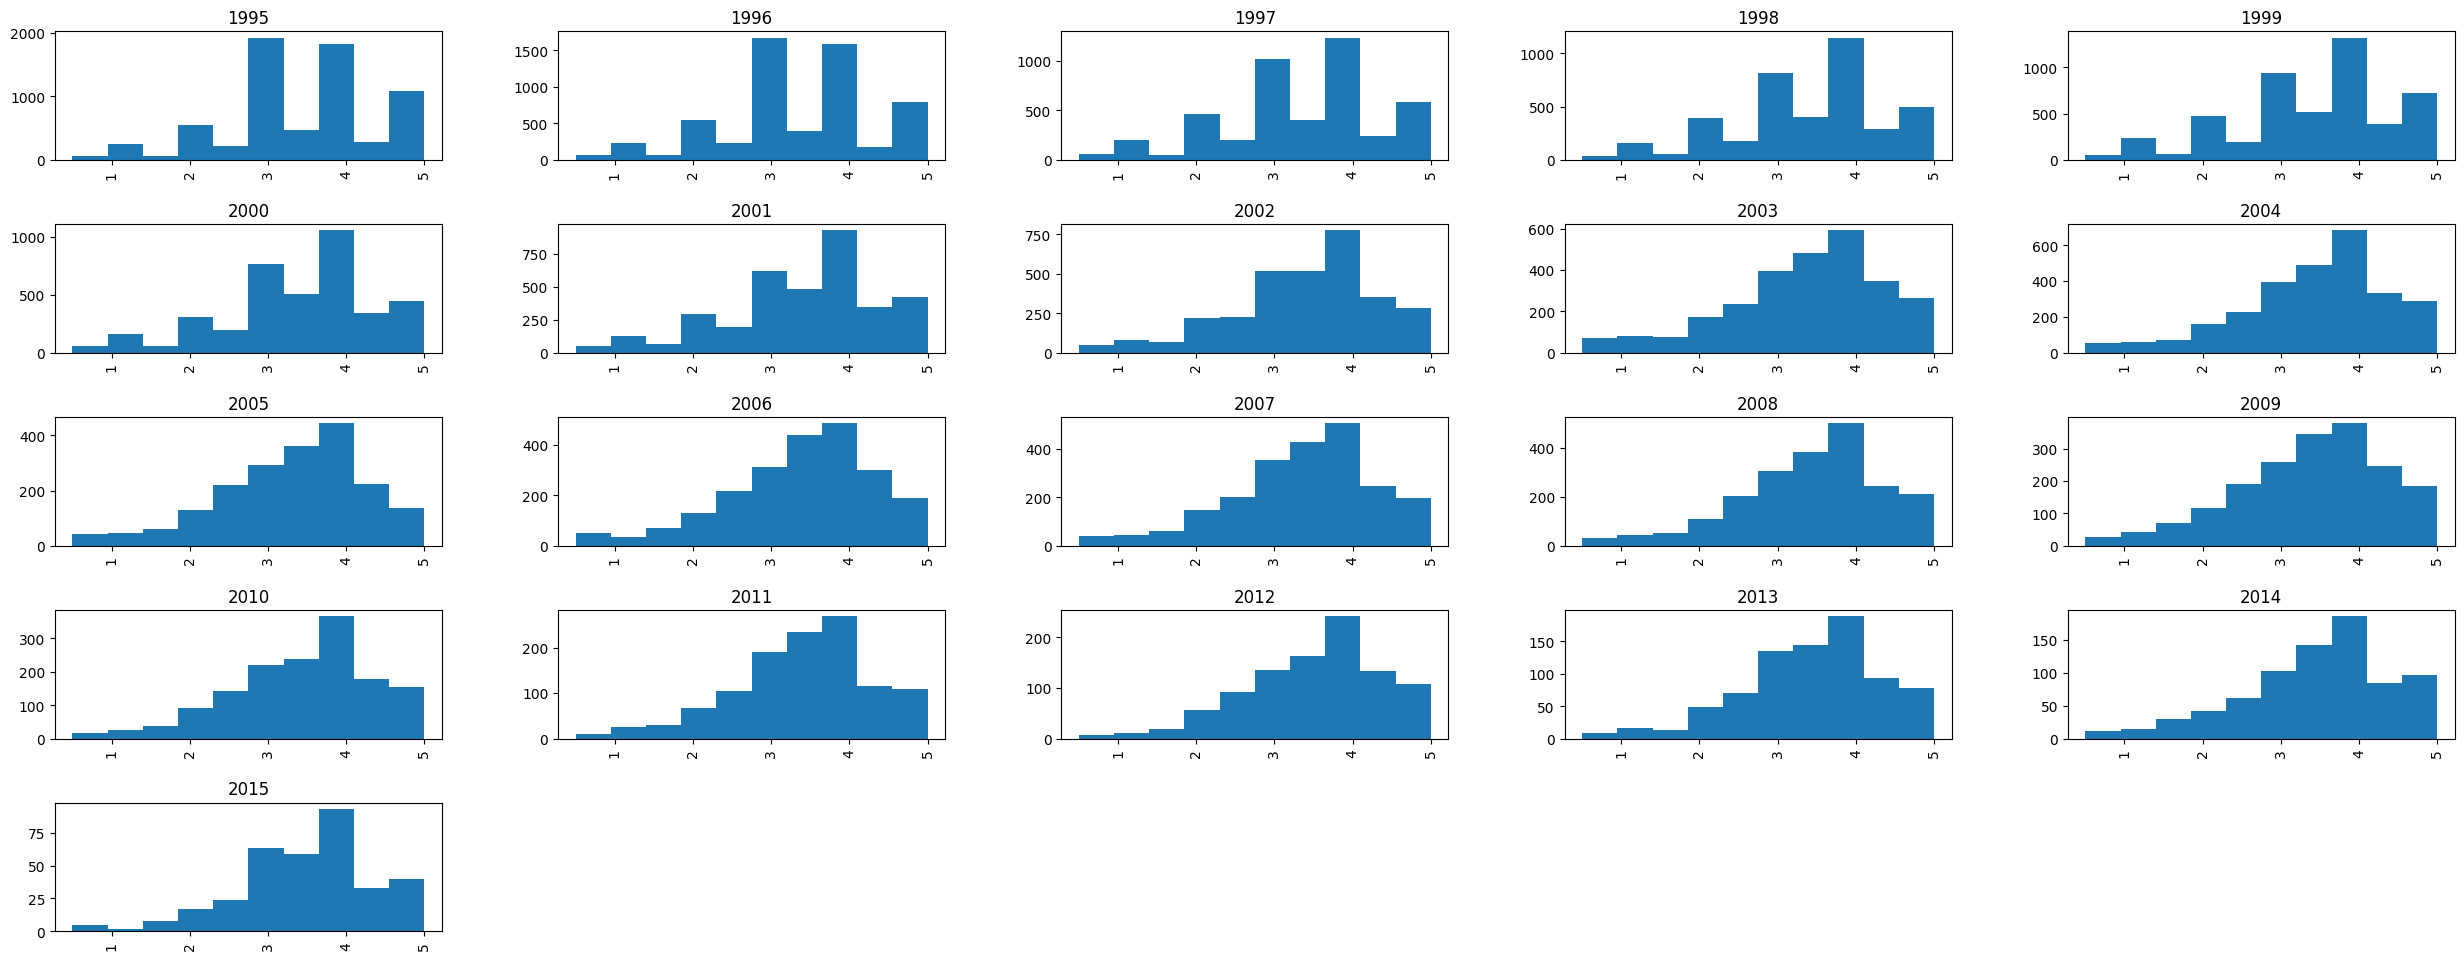

In [154]:
year_ratings['rating'].hist(by=year_ratings['year'], figsize=(30, 12));

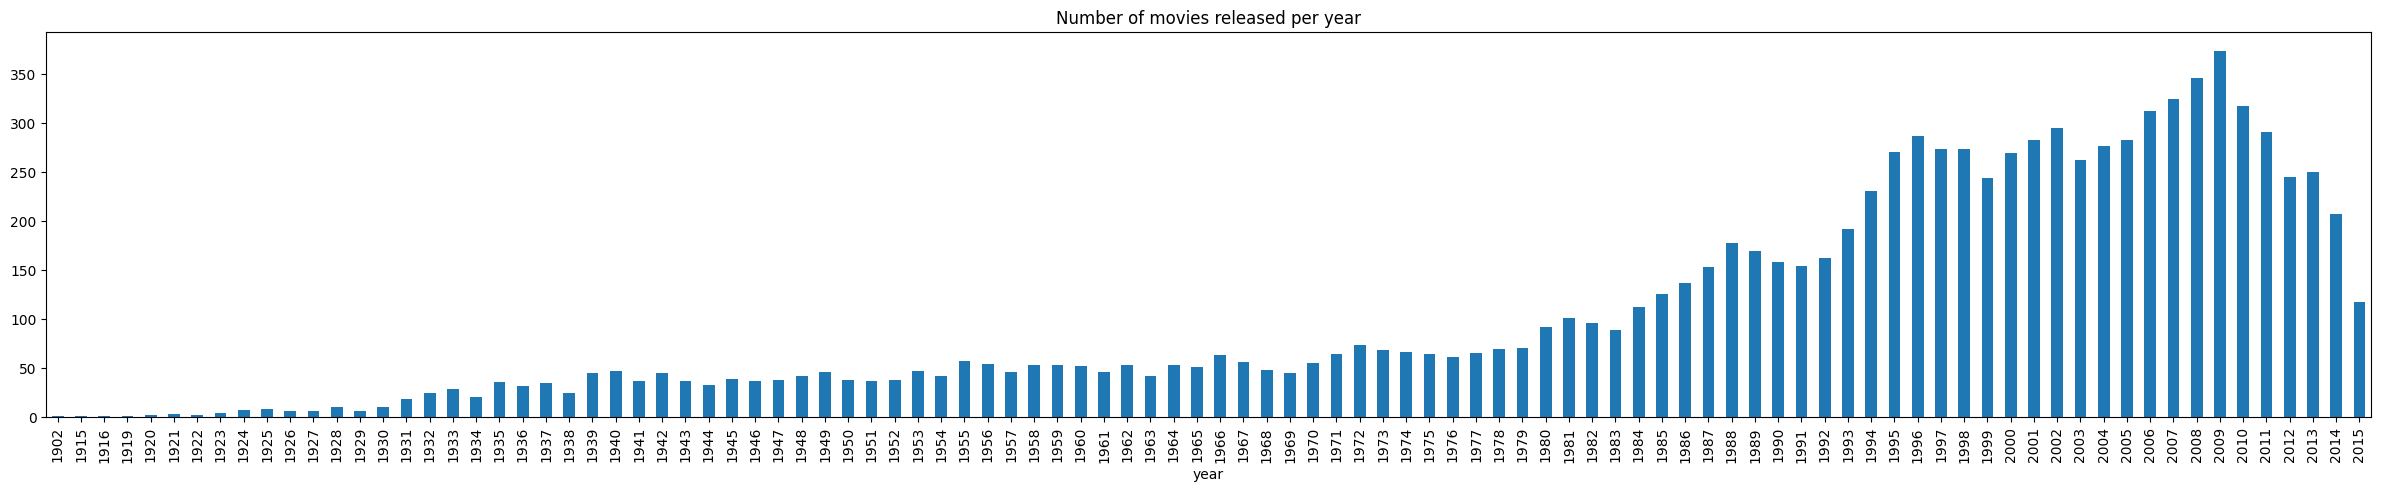

In [155]:
# Number of released movies per year
release_years = movie_data.year.unique()
release_years.sort()
df_temp = movie_data.groupby(['year'])['title'].count()
df_temp.plot.bar(x='year', y='movies', title='Number of movies released per year', figsize=(30, 5))
plt.show()

In [156]:
#Now let's make sure the data has been removed
movie_data.isnull().sum()

movieId    0
title      0
genres     0
year       0
dtype: int64

In [157]:
movie_data.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


Now we'll put perform one hot encoding for the genres and save it to the variable "genre_data"
It will contain one hot encoding performed on the genre column, so we can use it to get similarities to get the genre data

In [158]:
genre_data = movie_data['genres'].str.get_dummies('|')
print('genres available:' , genre_data.columns.values)

genres available: ['(no genres listed)' 'Action' 'Adventure' 'Animation' 'Children' 'Comedy'
 'Crime' 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'IMAX'
 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']


In [159]:
genre_data.head(10)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Now we'll visualise the data

In [160]:
movies_per_genre = genre_data.sum()
print(movies_per_genre)

(no genres listed)       6
Action                1737
Adventure             1164
Animation              401
Children               540
Comedy                3513
Crime                 1440
Documentary            415
Drama                 5219
Fantasy                670
Film-Noir              195
Horror                1001
IMAX                   152
Musical                409
Mystery                675
Romance               1788
Sci-Fi                 860
Thriller              2187
War                    503
Western                235
dtype: int64


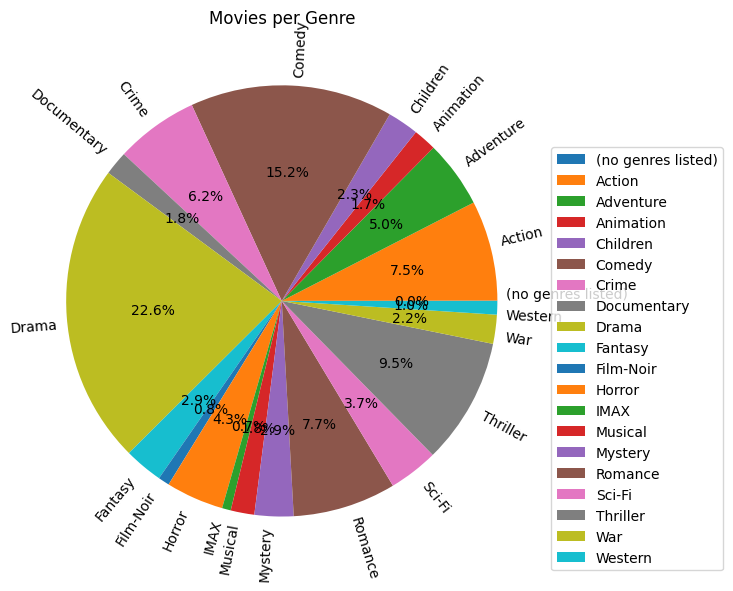

In [161]:
plt.figure(figsize=(8, 7))
plt.pie(movies_per_genre, labels=movies_per_genre.index, autopct='%.1f%%', labeldistance=1.04, rotatelabels=True)

plt.title('Movies per Genre')
plt.legend(loc=(1,0))
plt.show()

## Content Based Filtering 

Content-based filtering is a method utilized by recommendation frameworks to give customized recommendations to users based on their inclinations and past way of behaving. It works by dissecting the qualities or highlights of things and making a user profile based on their past cooperations with the framework.

The content-based filtering approach depends with the understanding that assuming a user loves a specific thing, they are probably going to appreciate different things that share comparable properties or elements. For instance, on the off chance that a user appreciates watching activity films, the framework will suggest other activity motion pictures based on the properties of the films they have recently watched, like the genre, actors, and directors.

The course of content-based filtering includes separating important highlights from the things, like catchphrases, genre, actors, and directors. The framework then contrasts the highlights of the things and the user's inclinations and produces a rundown of recommendations based on the comparability between the user profile and thing profiles.

One of the upsides of content-based filtering is that it can suggest things based on the particular interests of the user, regardless of whether the things are not well known among most of users. Giving recommendations without information on other users' preferences is likewise capable.

In any case, content-based filtering has limits, for example, the powerlessness to suggest things that are outside the user's previous way of behaving or inclinations. It likewise requires precise and pertinent thing credits to make exact thing profiles, which can be trying for specific kinds of things.

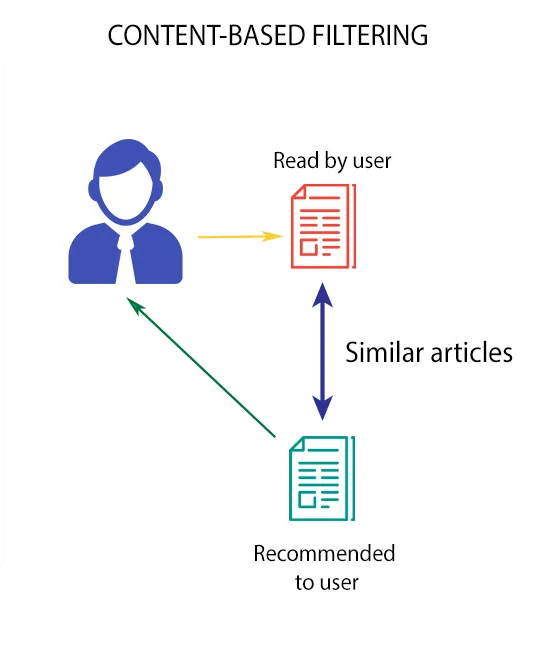

### Computing the recommendations for users

#### Getting the features for computing similarity

The features we will look at to compute the similarities betweeen the movies
- Genres
- Release year

In [162]:
movie_data.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [163]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [164]:
# Dropping the timestamp column
rating_data.drop(['timestamp'],axis = 1 , inplace = True)
rating_data.head()

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0


In [165]:
movie_features = movie_data.loc[:,['movieId','year']]

In [166]:
#Connenting it to the genres 
movie_features = pd.merge(movie_features, genre_data,left_index = True, right_index = True)

In [167]:
movie_features.head(10)

,movieId,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,1995,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,7,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,8,1995,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,1995,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,1995,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Performing the filtering with the features being genres

In [168]:
# Training the data with the genres
movie_features.iloc[:, 2:].head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [169]:
# Using Nearest neighbours as our model
model = NearestNeighbors(n_neighbors=10, metric='cosine')
model.fit(movie_features.iloc[:, 2:])

NearestNeighbors(metric='cosine', n_neighbors=10)

In [170]:
def content_recommender(movie_idx, feature,model):
    # using cosine similarity to find the n nearest neighbours
    distances,indices = model.kneighbors(feature)
    recommended_movies = pd.DataFrame([movie_data.iloc[idx] for idx in indices.flatten()])
    recommended_movies['distance'] = distances.flatten()
    
    return recommended_movies
    
    

In [171]:
# This shows the (weighted) graph of k-Neighbors for points in X.
# model.kneighbors_graph(movie_features.iloc[:, 2:]).toarray()

In [172]:
def find_idx_using_title (title):
    '''
    This function finds the index of the movie fromt he dataset using the movie title
    
    title = movie title
    '''
    idx = movie_data[movie_data['title'] == title].index
    return idx[0]

In [173]:
def find_title_using_idx(idx):
    '''
    This function returns the title once the index of the movie is produced
    
    idx = index
    '''
    
    title = movies.loc[idx]['title']
    return title

In [174]:
index = find_idx_using_title('Foreign Correspondent (1940)')

content_recommender(index, pd.DataFrame(movie_features.iloc[index, 2:]).transpose(), model)

,movieId,title,genres,year,distance
749,929,Foreign Correspondent (1940),Drama|Film-Noir|Mystery|Thriller,1940,0.000000
8593,78420,"House on Telegraph Hill, The (1951)",Drama|Film-Noir|Mystery|Thriller,1951,0.000000
3787,4848,Mulholland Drive (2001),Crime|Drama|Film-Noir|Mystery|Thriller,2001,0.105573
8790,82121,"Verdict, The (1946)",Crime|Drama|Film-Noir|Mystery|Thriller,1946,0.105573
5994,25920,"Blue Dahlia, The (1946)",Crime|Drama|Film-Noir|Mystery|Thriller,1946,0.105573
7728,59527,"Window, The (1949)",Drama|Film-Noir|Thriller,1949,0.133975
5985,25904,Ministry of Fear (1944),Drama|Film-Noir|Thriller,1944,0.133975
310,350,"Client, The (1994)",Drama|Mystery|Thriller,1994,0.133975
2783,3505,No Way Out (1987),Drama|Mystery|Thriller,1987,0.133975
9621,101088,Stoker (2013),Drama|Mystery|Thriller,2013,0.133975


Let's perform the filtering with the features being relaease year

In [175]:
model_rel =  NearestNeighbors(n_neighbors=10, metric='euclidean')
model_rel.fit(pd.DataFrame(movie_features.iloc[:, 1]))

NearestNeighbors(metric='euclidean', n_neighbors=10)

In [176]:
index = find_idx_using_title('Foreign Correspondent (1940)')

content_recommender(index, pd.DataFrame(movie_features.iloc[index, 1:2]).transpose(), model_rel)

,movieId,title,genres,year,distance
749,929,Foreign Correspondent (1940),Drama|Film-Noir|Mystery|Thriller,1940,0.0
2479,3097,"Shop Around the Corner, The (1940)",Comedy|Drama|Romance,1940,0.0
771,951,His Girl Friday (1940),Comedy|Romance,1940,0.0
1041,1282,Fantasia (1940),Animation|Children|Fantasy|Musical,1940,0.0
748,928,Rebecca (1940),Drama|Mystery|Romance|Thriller,1940,0.0
761,941,"Mark of Zorro, The (1940)",Adventure,1940,0.0
2880,3644,Dark Command (1940),Western,1940,0.0
528,596,Pinocchio (1940),Animation|Children|Fantasy|Musical,1940,0.0
719,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance,1940,0.0
1040,1281,"Great Dictator, The (1940)",Comedy|Drama|War,1940,0.0


Now we'll be using both genres and the release year

In [177]:
def genre_similarity(m1, m2):
    """
    m1 : movie 1 
    m2 : movie 2
    g1 : genre 1
    g2 : genre 2
    """
    g1 = m1[1:]
    g2 = m2[1:]
    
    return sklearn.metrics.pairwise.cosine_distances(g1.reshape(1, -1), g2.reshape(1, -1))    

#Getting the euclidean distance for similarity
def year_similarity(x1,x2):
    return sklearn.metrics.pairwise.euclidean_distances(x1[0].reshape(1, -1), x2[0].reshape(1, -1))

def calculate_distance(x1,x2):
    genre_sim= genre_similarity(x1, x2)
    year_sim= year_similarity(x1, x2)

    #return year_similarity + genre_similarity
    #return year_similarity * genre_similarity
    return (year_sim*0.2 + genre_sim*0.8)    

In [178]:
# pd.DataFrame(movie_features.iloc[:, 1:])

In [179]:
genre_year_model = NearestNeighbors(n_neighbors=10, metric=calculate_distance)
genre_year_model.fit(pd.DataFrame(movie_features.iloc[:, 1:]))

NearestNeighbors(metric=<function calculate_distance at 0x00000125AA62F420>,
                 n_neighbors=10)

In [180]:
index = find_idx_using_title("Toy Story (1995)")

content_recommender(index, pd.DataFrame(movie_features.iloc[index, 1:]).transpose(), genre_year_model)

,movieId,title,genres,year,distance
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0.000000
228,258,"Kid in King Arthur's Court, A (1995)",Adventure|Children|Comedy|Fantasy|Romance,1995,0.160000
12,13,Balto (1995),Adventure|Animation|Children,1995,0.180323
6471,31447,Magic in the Water (1995),Adventure|Children|Fantasy,1995,0.180323
626,745,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy,1995,0.180323
55,60,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy,1995,0.180323
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0.180323
214,243,Gordy (1995),Children|Comedy|Fantasy,1995,0.180323
712,888,Land Before Time III: The Time of the Great Gi...,Adventure|Animation|Children|Musical,1995,0.263344
4993,6857,Ninja Scroll (Jûbei ninpûchô) (1995),Action|Adventure|Animation|Fantasy,1995,0.263344


Recommend movies for the user

In [181]:
user_id = 58

In [182]:
print(rating_data['userId'].value_counts())

668    5678
575    2837
458    2086
232    1421
310    1287
       ... 
58       20
51       20
288      20
388      20
257      20
Name: userId, Length: 668, dtype: int64


In [183]:
def ratings_per_user (user_id):
    
    #Getting the row of the user
    user_rating = rating_data[rating_data['userId'] == user_id]
    
    #Dropping the userid column
    user_rating = user_rating.drop(['userId'], axis=1)
    
    return user_rating

In [184]:
rating_data

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0
...,...,...,...
105334,668,142488,4.0
105335,668,142507,3.5
105336,668,143385,4.0
105337,668,144976,2.5


In [185]:
rating_per_user =  ratings_per_user (user_id)

In [186]:
rating_per_user.head()

,movieId,rating
5112,158,2.5
5113,172,4.0
5114,543,0.5
5115,552,0.5
5116,596,2.5


In [187]:
# Creating a dataframe for th rated movies
rated_mov_df =  pd.merge(rating_per_user, movie_data, on='movieId')
rated_mov_df.head()

,movieId,rating,title,genres,year
0,158,2.5,Casper (1995),Adventure|Children,1995
1,172,4.0,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller,1995
2,543,0.5,So I Married an Axe Murderer (1993),Comedy|Romance|Thriller,1993
3,552,0.5,"Three Musketeers, The (1993)",Action|Adventure|Comedy|Romance,1993
4,596,2.5,Pinocchio (1940),Animation|Children|Fantasy|Musical,1940


In [188]:
def find_index_using_id(movie_id):
    idx = movie_data[movie_data['movieId'] == movie_id].index
    return idx[0]

In [189]:
content_b_rec = pd.DataFrame()
for index, row in tqdm(rating_per_user.iterrows()):
    movie_id = int(row['movieId'])
    rating = row['rating']
    features = pd.DataFrame(movie_features.iloc[find_index_using_id(movie_id), 1:]).transpose()
    recs_by_movie = content_recommender(movie_id, features, genre_year_model)
    # Multiplying by (1/rating), so that movies similar to those high rated get more chance
    # to appear in the top n list.
    # Adding 1 to avoid 0 values (0*1 = 0*5: ratings make no difference in this case)
    # The smaller relevance is, the better recommendation is
    recs_by_movie['relevance'] = (1+recs_by_movie['distance'])*(1/rating) 
    content_b_rec = pd.concat([content_b_rec, recs_by_movie], ignore_index=True)
    #print(recs)

20it [00:54,  2.75s/it]


In [190]:
# This will give us the most relevant titles for recommmendation with respect to the relevance

content_b_rec.nsmallest(20,'relevance').head(10)

,movieId,title,genres,year,distance,relevance
10,338,Virtuosity (1995),Action|Sci-Fi|Thriller,1995,0.000000,0.250000
11,76,Screamers (1995),Action|Sci-Fi|Thriller,1995,0.000000,0.250000
12,172,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller,1995,0.000000,0.250000
130,1674,Witness (1985),Drama|Romance|Thriller,1985,0.000000,0.250000
13,292,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,1995,0.107180,0.276795
110,596,Pinocchio (1940),Animation|Children|Fantasy|Musical,1940,0.000000,0.285714
111,1282,Fantasia (1940),Animation|Children|Fantasy|Musical,1940,0.000000,0.285714
14,89,Nick of Time (1995),Action|Thriller,1995,0.146803,0.286701
131,5471,Perfect (1985),Drama|Romance,1985,0.146803,0.286701
132,2146,St. Elmo's Fire (1985),Drama|Romance,1985,0.146803,0.286701


In [191]:
# This will give us the least relevant titles for recommmendation with respect to the relevance

content_b_rec.nlargest(20, 'relevance').head(10)

,movieId,title,genres,year,distance,relevance
128,2046,Flight of the Navigator (1986),Adventure|Children|Sci-Fi,1986,0.266667,2.533333
129,5437,"Manhattan Project, The (1986)",Comedy|Sci-Fi|Thriller,1986,0.266667,2.533333
32,499,Mr. Wonderful (1993),Comedy|Romance,1993,0.234315,2.468629
33,7844,"Legend, The (Legend of Fong Sai-Yuk, The) (Fon...",Action|Comedy,1993,0.234315,2.468629
34,33629,Airborne (1993),Adventure|Comedy,1993,0.234315,2.468629
35,497,Much Ado About Nothing (1993),Comedy|Romance,1993,0.234315,2.468629
36,1441,Benny & Joon (1993),Comedy|Romance,1993,0.234315,2.468629
37,3208,Loaded Weapon 1 (National Lampoon's Loaded Wea...,Action|Comedy,1993,0.234315,2.468629
38,6233,Born Yesterday (1993),Comedy|Romance,1993,0.234315,2.468629
39,4686,Weekend at Bernie's II (1993),Adventure|Comedy,1993,0.234315,2.468629


## Collaborative filtering

The content based recommender is just fit for recommending films which are near a specific film. To utilise the similarities between the users, we use the collaborative filter.Collaborative filtering systems
examine the client's way of behaving and inclinations and anticipate what
they would like in view of closeness with different clients.

There are two approaches to collaborative filtering:
- User based recommendation
- Item based recommendation

### User based Recommendation

These systems prescribe items to a client that comparable users have loved. For estimating the similarity between two clients we can either utilize pearson correlation or cosine similarity. The ratings dataset will give us the rating every client provided for every film.

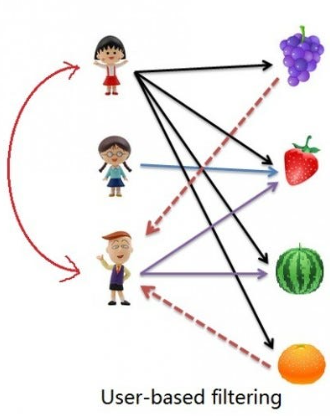

For user based collaborative filtering , recommenations are based on what 
other users with similar taste might like

Checking our number of users per year

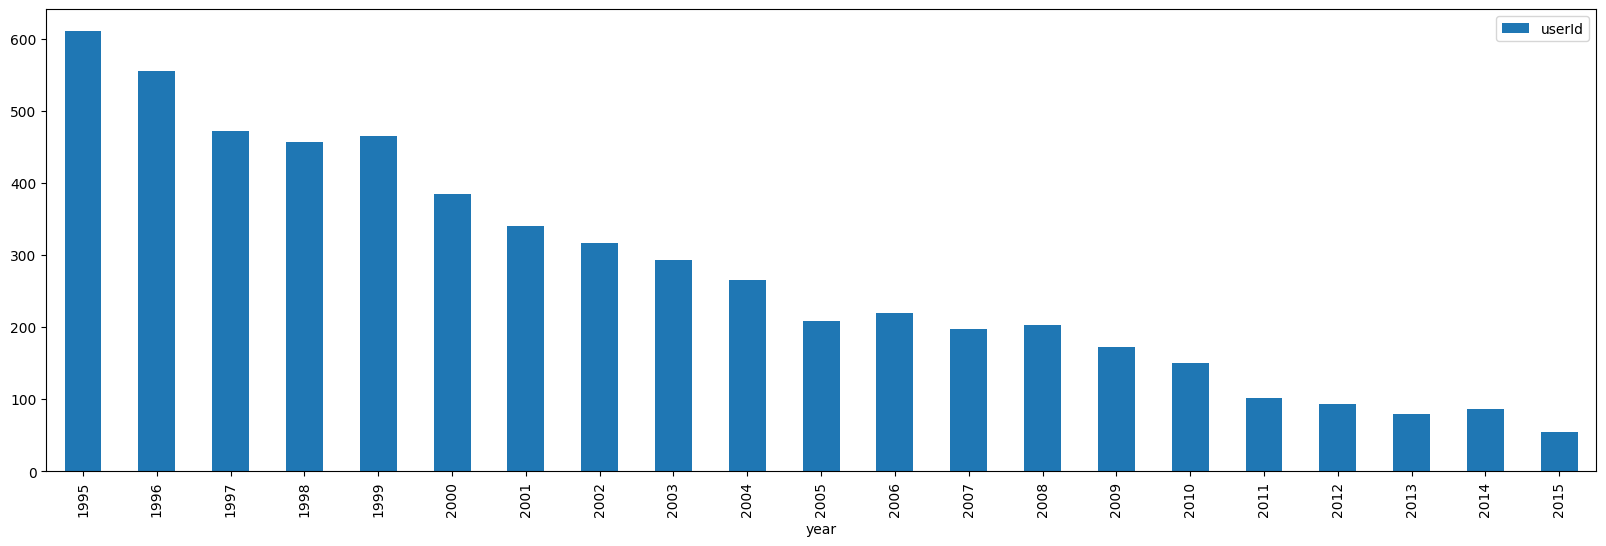

In [192]:
df_temp = year_ratings[['year', 'userId']].groupby(['year']).nunique().reset_index()
df_temp.plot.bar(x='year', y='userId',figsize=(20,6));

In [193]:
movie_data_u = pd.read_csv(movie_file)
rating_data_u = pd.read_csv(rating_file)

In [194]:
data = movie_data_u.merge(rating_data_u, how = "left", on = "movieId")
data.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,8.590469e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1.303501e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,5.0,8.586109e+08
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.0,8.508158e+08
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14.0,4.0,8.517663e+08


In [195]:
#creating a pivot table, with the userIDs in the index, 

user_df = data.pivot_table(index = ["userId"], columns = ["title"], values = "rating")
user_df.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 (1979),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),a/k/a Tommy Chong (2005),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Performing a user based selection

In [196]:
random_user = int(pd.Series(user_df.index).sample(1, random_state=45).values)
random_user

196

In [197]:
# Creating a new dataframe named random_user_df consisting of observation units of the selected user

random_user_df = user_df[user_df.index == random_user]
random_user_df

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 (1979),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),a/k/a Tommy Chong (2005),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
196.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
# Assigning the movies that the selected user has voted to a list called movies_watched

movies_watched = random_user_df.columns[random_user_df.notna().any()].tolist()
movies_watched[:5]


['Ace Ventura: Pet Detective (1994)',
 'Ace Ventura: When Nature Calls (1995)',
 'Aladdin (1992)',
 'Apollo 13 (1995)',
 'Babe (1995)']

In [199]:
# Select the columns of the movies watched by the selected user from user_movie_df and create a new dataframe named movies_watched_df

movies_watched_df = user_df[movies_watched]
movies_watched_df

title,Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Aladdin (1992),Apollo 13 (1995),Babe (1995),"Babysitter, The (1995)",Bad Boys (1995),Batman (1989),Batman Forever (1995),Beauty and the Beast (1991),...,Toy Story (1995),True Lies (1994),Twister (1996),Under Siege 2: Dark Territory (1995),"Usual Suspects, The (1995)",Virtuosity (1995),Wallace & Gromit: The Best of Aardman Animation (1996),Waterworld (1995),When a Man Loves a Woman (1994),While You Were Sleeping (1995)
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.5,NaN,NaN,...,NaN,3.0,3.0,0.5,4.0,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,3.0,4.0,5.0,NaN,NaN,3.0,NaN,4.0,...,NaN,3.0,3.0,NaN,5.0,NaN,NaN,NaN,NaN,3.0
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,1.0,NaN,3.5,NaN,NaN,NaN,NaN,0.5,NaN,4.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN


In [200]:
# Creating a new dataframe named user_movie_count with information about how many movies each user has watched

user_movie_count = movies_watched_df.T.notnull().sum()

user_movie_count = user_movie_count.reset_index()

user_movie_count.columns = ["userId", "movie_count"]

user_movie_count

,userId,movie_count
0,1.0,25
1,2.0,7
2,3.0,44
3,4.0,3
4,5.0,12
...,...,...
663,664.0,11
664,665.0,15
665,666.0,7
666,667.0,16


In [201]:
# We consider those who watch 60 percent or more of the movies voted by the selected user as similar users.

perc = len(movies_watched) * 60 / 100
users_same_movies = user_movie_count[user_movie_count["movie_count"] > perc]["userId"]
users_same_movies

28      29.0
108    109.0
155    156.0
159    160.0
195    196.0
219    220.0
309    310.0
325    326.0
443    444.0
457    458.0
468    469.0
574    575.0
606    607.0
667    668.0
Name: userId, dtype: float64

Getting similar user actions

In [202]:
# Filter the movies_watched_df dataframe to find the ids of the users that are similar to the selected user in the user_same_movies list.
movies_watched_df = pd.concat([movies_watched_df[movies_watched_df.index.isin(users_same_movies)],
                      random_user_df[movies_watched]])
movies_watched_df

title,Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Aladdin (1992),Apollo 13 (1995),Babe (1995),"Babysitter, The (1995)",Bad Boys (1995),Batman (1989),Batman Forever (1995),Beauty and the Beast (1991),...,Toy Story (1995),True Lies (1994),Twister (1996),Under Siege 2: Dark Territory (1995),"Usual Suspects, The (1995)",Virtuosity (1995),Wallace & Gromit: The Best of Aardman Animation (1996),Waterworld (1995),When a Man Loves a Woman (1994),While You Were Sleeping (1995)
userId,,,,,,,,,,,,,,,,,,,,,
29.0,3.0,3.0,3.0,3.0,NaN,NaN,3.0,3.0,2.0,3.0,...,4.0,3.0,3.0,3.0,4.0,NaN,NaN,3.0,NaN,3.0
109.0,2.0,1.0,5.0,5.0,5.0,NaN,5.0,5.0,3.0,4.0,...,5.0,5.0,4.0,2.0,5.0,NaN,5.0,5.0,NaN,NaN
156.0,4.0,5.0,5.0,5.0,5.0,NaN,NaN,4.0,5.0,5.0,...,5.0,5.0,3.0,NaN,NaN,NaN,NaN,4.0,NaN,5.0
160.0,NaN,NaN,4.0,5.0,3.0,3.0,3.0,3.0,4.0,NaN,...,NaN,4.0,3.0,NaN,5.0,NaN,NaN,4.0,NaN,4.0
196.0,2.0,2.0,4.0,3.0,4.0,3.0,2.0,3.0,3.0,4.0,...,4.0,3.0,3.0,3.0,4.0,2.0,4.0,2.0,3.0,3.0
220.0,3.0,1.0,4.0,2.0,4.0,NaN,3.5,3.5,3.0,3.5,...,4.0,3.5,2.5,NaN,4.0,NaN,4.5,3.5,NaN,3.0
310.0,1.5,1.5,NaN,3.5,NaN,NaN,3.5,3.5,2.5,2.5,...,3.0,2.5,3.0,NaN,4.0,2.5,NaN,3.0,3.0,3.0
326.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,3.0,5.0,4.0,...,NaN,3.0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,3.0
444.0,3.0,3.0,4.0,5.0,3.0,NaN,NaN,4.0,4.0,4.0,...,NaN,4.0,5.0,5.0,NaN,3.0,NaN,NaN,NaN,4.0


In [203]:
# Finding correlations between users

corr_df = movies_watched_df.T.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['user_1', 'user_2']
corr_df = corr_df.reset_index()
corr_df.head(5)

,user_1,user_2,corr
0,310.0,156.0,-0.171324
1,156.0,668.0,-0.148093
2,156.0,458.0,-0.129497
3,458.0,326.0,-0.107494
4,156.0,109.0,-0.096291


In [204]:
#Filtering users with correlation with the selected user

top_users = corr_df[(corr_df["user_1"] == random_user) & (corr_df["corr"] >= 0.25)][
    ["user_2", "corr"]].reset_index(drop=True)

top_users = top_users.sort_values(by='corr', ascending=False)
top_users.rename(columns={"user_2": "userId"}, inplace=True)
top_users

,userId,corr
5,196.0,1.000000
4,310.0,0.474565
3,469.0,0.417882
2,444.0,0.404541
1,607.0,0.314998
0,29.0,0.251636


In [205]:
# Combining the top_users dataframe with the ratings dataset
top_users_ratings = top_users.merge(rating_data[["userId", "movieId", "rating"]], how='inner')
top_users_ratings = top_users_ratings[top_users_ratings["userId"] != random_user]
top_users_ratings.head(5)

,userId,corr,movieId,rating
123,310.0,0.474565,1,3.0
124,310.0,0.474565,2,2.5
125,310.0,0.474565,6,3.5
126,310.0,0.474565,7,3.0
127,310.0,0.474565,10,2.5


Movie recommendation

In [206]:
# Multiplying the corr and rating of each user

top_users_ratings['weighted_rating'] = top_users_ratings['corr'] * top_users_ratings['rating']
top_users_ratings.head(10)


,userId,corr,movieId,rating,weighted_rating
123,310.0,0.474565,1,3.0,1.423696
124,310.0,0.474565,2,2.5,1.186413
125,310.0,0.474565,6,3.5,1.660979
126,310.0,0.474565,7,3.0,1.423696
127,310.0,0.474565,10,2.5,1.186413
128,310.0,0.474565,11,3.5,1.660979
129,310.0,0.474565,14,3.5,1.660979
130,310.0,0.474565,15,2.5,1.186413
131,310.0,0.474565,16,3.0,1.423696
132,310.0,0.474565,17,3.0,1.423696


In [207]:
# Get the average value of the weighted ratings of all users for each movie

recommendation_df = top_users_ratings.groupby('movieId').agg({"weighted_rating": "mean"})
recommendation_df = recommendation_df.reset_index()
recommendation_df.head(5)

,movieId,weighted_rating
0,1,1.235970
1,2,0.940985
2,3,1.137421
3,4,1.253647
4,6,1.399762


In [208]:
# Selecting movies with a rating greater than a value

recommendation_df= recommendation_df[recommendation_df["weighted_rating"] > 1.5]
recommendation_df["weighted_rating"].describe()
movies_recommend = recommendation_df.sort_values("weighted_rating", ascending=False)#.head(5)
movies_recommend.head(5)

,movieId,weighted_rating
591,1293,2.372827
1983,40414,2.135544
2082,55276,2.135544
1327,3462,2.135544
556,1246,2.112478


In [209]:
# Recommend movies for the user

recommend_movies = movies_recommend.merge(movie_data_u[["movieId", "title"]])
recommend_movies.head(10)

,movieId,weighted_rating,title
0,1293,2.372827,Gandhi (1982)
1,40414,2.135544,Joyeux Noël (Merry Christmas) (2005)
2,55276,2.135544,Michael Clayton (2007)
3,3462,2.135544,Modern Times (1936)
4,1246,2.112478,Dead Poets Society (1989)
5,1218,2.089412,"Killer, The (Die xue shuang xiong) (1989)"
6,2959,1.973909,Fight Club (1999)
7,280,1.960482,Murder in the First (1995)
8,307,1.903537,Three Colors: Blue (Trois couleurs: Bleu) (1993)
9,1172,1.903537,Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [210]:
rating_data[rating_data['userId'] == random_user].sort_values(by='rating', ascending=False)

,userId,movieId,rating
27272,196,356,5.0
27330,196,780,5.0
27304,196,527,5.0
27222,196,110,5.0
27273,196,357,4.0
...,...,...,...
27314,196,585,1.0
27236,196,181,1.0
27309,196,546,1.0
27245,196,231,1.0


### Item based collaboration 

Rather than estimating the similarity among users, the item-based together CF prescribes items based with respect to their similarity with the items that the objective client evaluated. In like manner, the similarity can be registered with Pearson Correlation or Cosine Similarity.

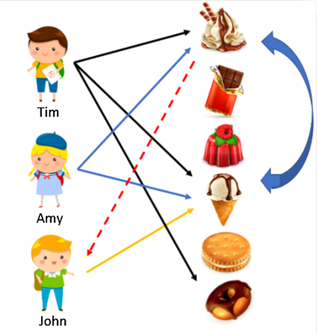

Item based recommendation is a type of collaborative filtering for recommender frameworks based on the comparability between items determined utilizing individuals' evaluations of those items.

In [211]:
selected_movie = user_df['(500) Days of Summer (2009)']
selected_movie

userId
1.0      NaN
2.0      NaN
3.0      NaN
4.0      NaN
5.0      NaN
        ... 
664.0    NaN
665.0    NaN
666.0    NaN
667.0    NaN
668.0    2.0
Name: (500) Days of Summer (2009), Length: 668, dtype: float64

In [212]:
user_df.corrwith(selected_movie).sort_values(ascending=False).head(10)

C:\Users\aeade\.conda\envs\compvision\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\aeade\.conda\envs\compvision\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


title
(500) Days of Summer (2009)                              1.0
Nashville (1975)                                         1.0
Nightmare on Elm Street 4: The Dream Master, A (1988)    1.0
Nightmare on Elm Street 2: Freddy's Revenge, A (1985)    1.0
Nighthawks (1981)                                        1.0
Night of the Hunter, The (1955)                          1.0
Night of the Comet (1984)                                1.0
Night Falls on Manhattan (1996)                          1.0
New York Stories (1989)                                  1.0
Nell (1994)                                              1.0
dtype: float64

# Matrix factorisation

A recommender framework has two elements — users and items. Suppose we have m users and n items. The objective of our recommendation framework is to construct a mxn matrix (called the utility matrix) which comprises of the rating (or ipreference) for every user-item pair. At first, this matrix is normally extremely inadequate on the grounds that we just have ratings for a predetermined number of user-item coordinates.

Presently, we want to populate this matrix by tracking down likenesses among users and items. To get an instinct, for instance, we see that User3 and User4 gave a similar rating to Batman,
so we can expect the users are comparable and they'd feel the same way about Spiderman and foresee that User3 would give a rating of 4 to Spiderman. Practically speaking, nonetheless, this isn't as clear since there are various users collaborating with a wide range of items.

Practically speaking, The matrix is populated by deteriorating (or factorizing) the Utility matrix into two tall and thin networks. The decomposition has the condition:

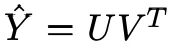

where U is m x k and V is n x k. U is a portrayal of users in some low layered space, and V is a portrayal of items. For a user I, uᵢ gives the portrayal of that user, and for an item e, vₑ gives the portrayal of that item.

The rating prediction for a user-item pair is simply:

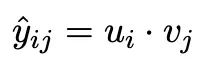)
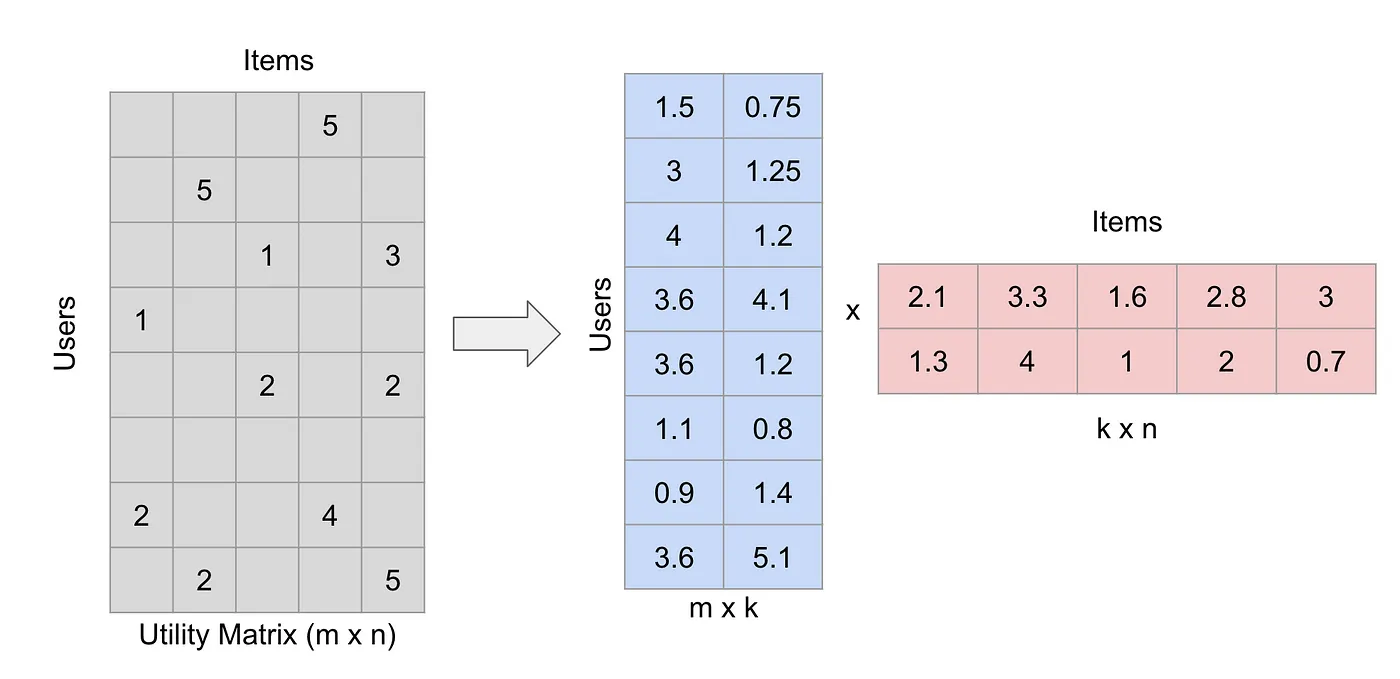

We want to track down the ideal embeddings for every user and every item. We can then involve these embeddings to make expectations for any user-item pair by taking the dot product of user embedding and item inserting

Cost function: We are attempting to limit the Mean squared error over the utility matrix. Here N is the quantity of non-clear components in the utility matrix.

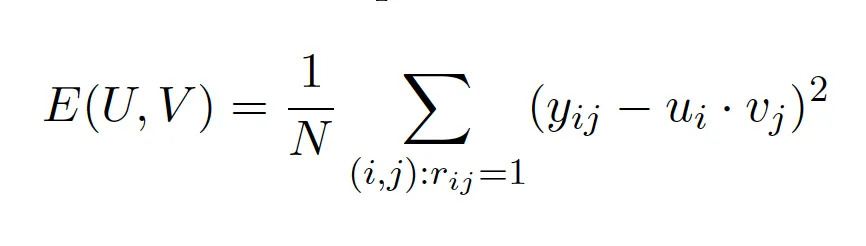

In [213]:
#pip install surprise

In [214]:
import numpy as np
import pandas as pd
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
#from surprise import Reader, Dataset, evaluate, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import Reader, Dataset,  KNNBasic, SVD, NMF

In [215]:
import os
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

In [216]:
movie_data_u

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
10324,146684,Cosmic Scrat-tastrophe (2015),Animation|Children|Comedy
10325,146878,Le Grand Restaurant (1966),Comedy
10326,148238,A Very Murray Christmas (2015),Comedy
10327,148626,The Big Short (2015),Drama


In [217]:
matrix_mov = movie_data_u.copy()
matrix_rat = rating_data_u.copy()

In [218]:
matrix_data = matrix_mov.merge(matrix_rat, how="left" , on= "movieId")

matrix_data.index = matrix_data.index +1 
matrix_data.head()

,movieId,title,genres,userId,rating,timestamp
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,8.590469e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1.303501e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,5.0,8.586109e+08
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.0,8.508158e+08
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14.0,4.0,8.517663e+08


In [219]:
matrix_rat[['userId', 'movieId', 'rating']].head(10)

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0
5,1,110,4.0
6,1,150,3.0
7,1,161,4.0
8,1,165,3.0
9,1,204,0.5


In [220]:
reader = Reader(line_format='user item rating timestamp', sep='\t')

reader = Reader(rating_scale=(0.5, 5.0))
#reader = Reader(rating_scale=(1, 5))

In [221]:
data = Dataset.load_from_df(matrix_rat[['userId', 'movieId', 'rating']], reader)

In [222]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)


C:\Users\aeade\AppData\Local\Temp\ipykernel_3752\1679502854.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
C:\Users\aeade\AppData\Local\Temp\ipykernel_3752\1679502854.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
C:\Users\aeade\AppData\Local\Temp\ipykernel_3752\1679502854.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\aeade\AppData\Local\Temp\ipykernel_3752\1679502854.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))


In [223]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.870440,0.671198,0.906769,0.098582
NMF,0.925709,0.710712,1.527000,0.083576
KNNBasic,0.955703,0.736308,0.138867,0.834780
NormalPredictor,1.426976,1.140080,0.074771,0.055187


In [224]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8662


0.8661740098093365

From the result of the RMSE above, we see that the result is quite good

In [225]:
#Now predicting ratings a user will give to a movie
algo.predict(uid=1.0, iid=541, verbose=True)

user: 1.0        item: 541        r_ui = None   est = 4.37   {'was_impossible': False}


Prediction(uid=1.0, iid=541, r_ui=None, est=4.372239580254547, details={'was_impossible': False})

In [226]:
algo.predict(uid=1.0, iid=356, verbose=True)

user: 1.0        item: 356        r_ui = None   est = 3.66   {'was_impossible': False}


Prediction(uid=1.0, iid=356, r_ui=None, est=3.6640133059866136, details={'was_impossible': False})

Calculating threshold and precision score for different threshold

In [227]:
#Calculate TRUE_POSITIVE,FALSE_POSITIVE,TRUE_NEGATIVE,FALSE_NEGATIVE at every threshold level (0.0 - 5.0)

final = []

for threshold in np.arange(0, 5.5, 0.5):
  true_positive=0
  false_negative=0
  false_positive=0
  true_negative=0
  temp = []

  for u_id, _, true_r, estimated_rat, _ in predictions:
    if(true_r>=threshold):
      if(estimated_rat>=threshold):
        true_positive = true_positive+1
      else:
        false_negative = false_negative+1
    else:
      if(estimated_rat>=threshold):
        false_positive = false_positive+1
      else:
        true_negative = true_negative+1   

    if true_positive == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = true_positive / (true_positive + false_positive)
      recall = true_positive / (true_positive + false_negative)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, true_positive,false_positive,true_negative ,false_negative, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'true_positive', 2: 'false_positive', 3: 'true_negative', 4:'false_negative', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,true_positive,false_positive,true_negative,false_negative,Precision,Recall,F1
0,0.0,26335,0,0,0,1.000000,1.000000,1.000000
1,0.5,26335,0,0,0,1.000000,1.000000,1.000000
2,1.0,26057,273,1,4,0.989632,0.999847,0.994713
3,1.5,25219,1083,20,13,0.958824,0.999485,0.978732
4,2.0,24760,1403,95,77,0.946375,0.996900,0.970980
5,2.5,22448,2852,577,458,0.887273,0.980005,0.931336
6,3.0,18817,2399,2396,2723,0.886925,0.873584,0.880204
7,3.5,11213,2761,7455,4906,0.802419,0.695639,0.745223
8,4.0,4925,1029,12234,8147,0.827175,0.376759,0.517713
9,4.5,743,345,20178,5069,0.682904,0.127839,0.215362


After choosing your preferred thrshold value, we choose our optimal k value below

In [228]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_estimated_rat_true = defaultdict(list)
    for u_id, _, true_r, estimated_rat, _ in predictions:
        user_estimated_rat_true[u_id].append((estimated_rat, true_r))

    precisions = dict()
    recalls = dict()
    for u_id, user_ratings in user_estimated_rat_true.items():

        # Sort user ratings by estimated_ratimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        num_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        num_reccm_k = sum((estimated_rat >= threshold) for (estimated_rat, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        num_rel_and_rec_k = sum(((true_r >= threshold) and (estimated_rat >= threshold))
                              for (estimated_rat, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[u_id] = num_rel_and_rec_k / num_reccm_k if num_reccm_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[u_id] = num_rel_and_rec_k / num_rel if num_rel != 0 else 1

    #true_positive = num_rel_and_rec_k
    #false_negative =  num_rel - true_positive
    #false_positive = num_reccm_k - true_positive
    return precisions, recalls


In [229]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results


[{'K': 2, 'Precision': 0.9520958083832335, 'Recall': 0.17301420914834692},
 {'K': 3, 'Precision': 0.9476047904191613, 'Recall': 0.25033940593117576},
 {'K': 4, 'Precision': 0.9449850299401196, 'Recall': 0.32292576209266777},
 {'K': 5, 'Precision': 0.9392215568862269, 'Recall': 0.3846064840501795},
 {'K': 6, 'Precision': 0.934630738522954, 'Recall': 0.43714176260611065},
 {'K': 7, 'Precision': 0.9313159395494711, 'Recall': 0.48321494671571746},
 {'K': 8, 'Precision': 0.9271457085828338, 'Recall': 0.5229222993480748},
 {'K': 9, 'Precision': 0.9234655688622768, 'Recall': 0.5557583703963702},
 {'K': 10, 'Precision': 0.9224342980705245, 'Recall': 0.5882505629181347}]

Now building the model with the full dataset to recommend movies for users

In [230]:
full_data = data.build_full_trainset()   #Build on entire data set
algo = SVD()
algo.fit(full_data)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
#testset = trainset.build_anti_testset()

#Predicting the ratings for testset
#predictions = algo.test(testset)

In [231]:
algo.predict(uid=1.0, iid=541, verbose=True)

user: 1.0        item: 541        r_ui = None   est = 3.89   {'was_impossible': False}


Prediction(uid=1.0, iid=541, r_ui=None, est=3.891701132378968, details={'was_impossible': False})

In [232]:
def get_top_n(predictions, n=10):
    """
    This function shows the top recommendations made by our algorithm for each user

    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for u_id, m_id, true_r, est, _ in predictions:
        top_n[u_id].append((m_id, est))

    # Sorting the predictions per user to get the k highest ones.
    for u_id, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[u_id] = user_ratings[:n]

    return top_n

trainset = full_data
algo = SVD()
algo.fit(trainset)

testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
recomms = {'user_id':[],'movie_Id':[]}
for u_id, user_ratings in top_n.items():
    print(u_id, [m_id for (m_id, _) in user_ratings])

1 [923, 2313, 3000, 1193, 1224, 6870, 922, 1203, 46578, 5618]
2 [7099, 1178, 92259, 7502, 50, 318, 1172, 6870, 527, 5995]
3 [1136, 2959, 318, 92259, 1172, 30749, 48516, 1213, 1212, 745]
4 [6016, 1221, 923, 930, 3000, 50, 5618, 110, 1178, 1172]
5 [912, 1276, 1212, 48516, 1172, 800, 1217, 923, 922, 2917]
6 [1248, 1219, 858, 7502, 318, 1221, 1945, 80906, 904, 912]
7 [6016, 92259, 1233, 7099, 599, 912, 3000, 31658, 6870, 5971]
8 [3000, 923, 1248, 5952, 1252, 5618, 930, 1178, 5971, 92259]
9 [858, 923, 1136, 904, 912, 1221, 1248, 1213, 4973, 3000]
10 [904, 48516, 1207, 1224, 5618, 858, 541, 922, 908, 1172]
11 [44555, 923, 1197, 2858, 1230, 1235, 318, 29, 1284, 1207]
12 [318, 1198, 923, 1291, 3000, 1196, 7099, 745, 44555, 4993]
13 [318, 858, 7099, 923, 44555, 1221, 1203, 356, 908, 48516]
14 [923, 858, 912, 527, 1252, 1212, 1276, 1223, 1172, 7099]
15 [47, 110, 150, 161, 318, 356, 457, 527, 593, 597]
16 [1136, 1233, 48516, 904, 5618, 923, 2357, 1172, 1217, 1178]
17 [1198, 1212, 1172, 1217, 7913